# A Reverse Image Search Using a CNN

## Preparation

### import necessary libraries
- keras

In [2]:
import os
import keras #tensorflow backend
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import pickle
from scipy.spatial import distance

### Prepare the dataset!
- 5400 Animal Images in 90 categories from https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals

In [9]:
folder = './animals/animals/'
sub_folders = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))]
print(sub_folders)


['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


### Check the Model!
- load ResNet50 from keras
- pre-trained weights from ImageNet

In [6]:
model = keras.applications.ResNet50(weights='imagenet', include_top=True)
model.summary()



Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                     

## Indexing Phase

### Preprocessing
ResNet50 needs images to be 224x224

In [7]:
# inputs: file path, model
# output: original image, preprocessed array
# resizes the image to fit the given model and returns og image and the preprocessed image
def preprocess_image(image_path, model):
    # resizes image
    img = image.load_img(image_path, target_size=model.input_shape[1:3])
    # converts image to np array
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

### Feature Extraction

In [8]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("avg_pool").output)
feat_extractor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block1_2_conv (Conv2  (None, 56, 56, 64)           36928     ['conv2_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block1_2_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block1_2_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

What is the output of the feature extractor?
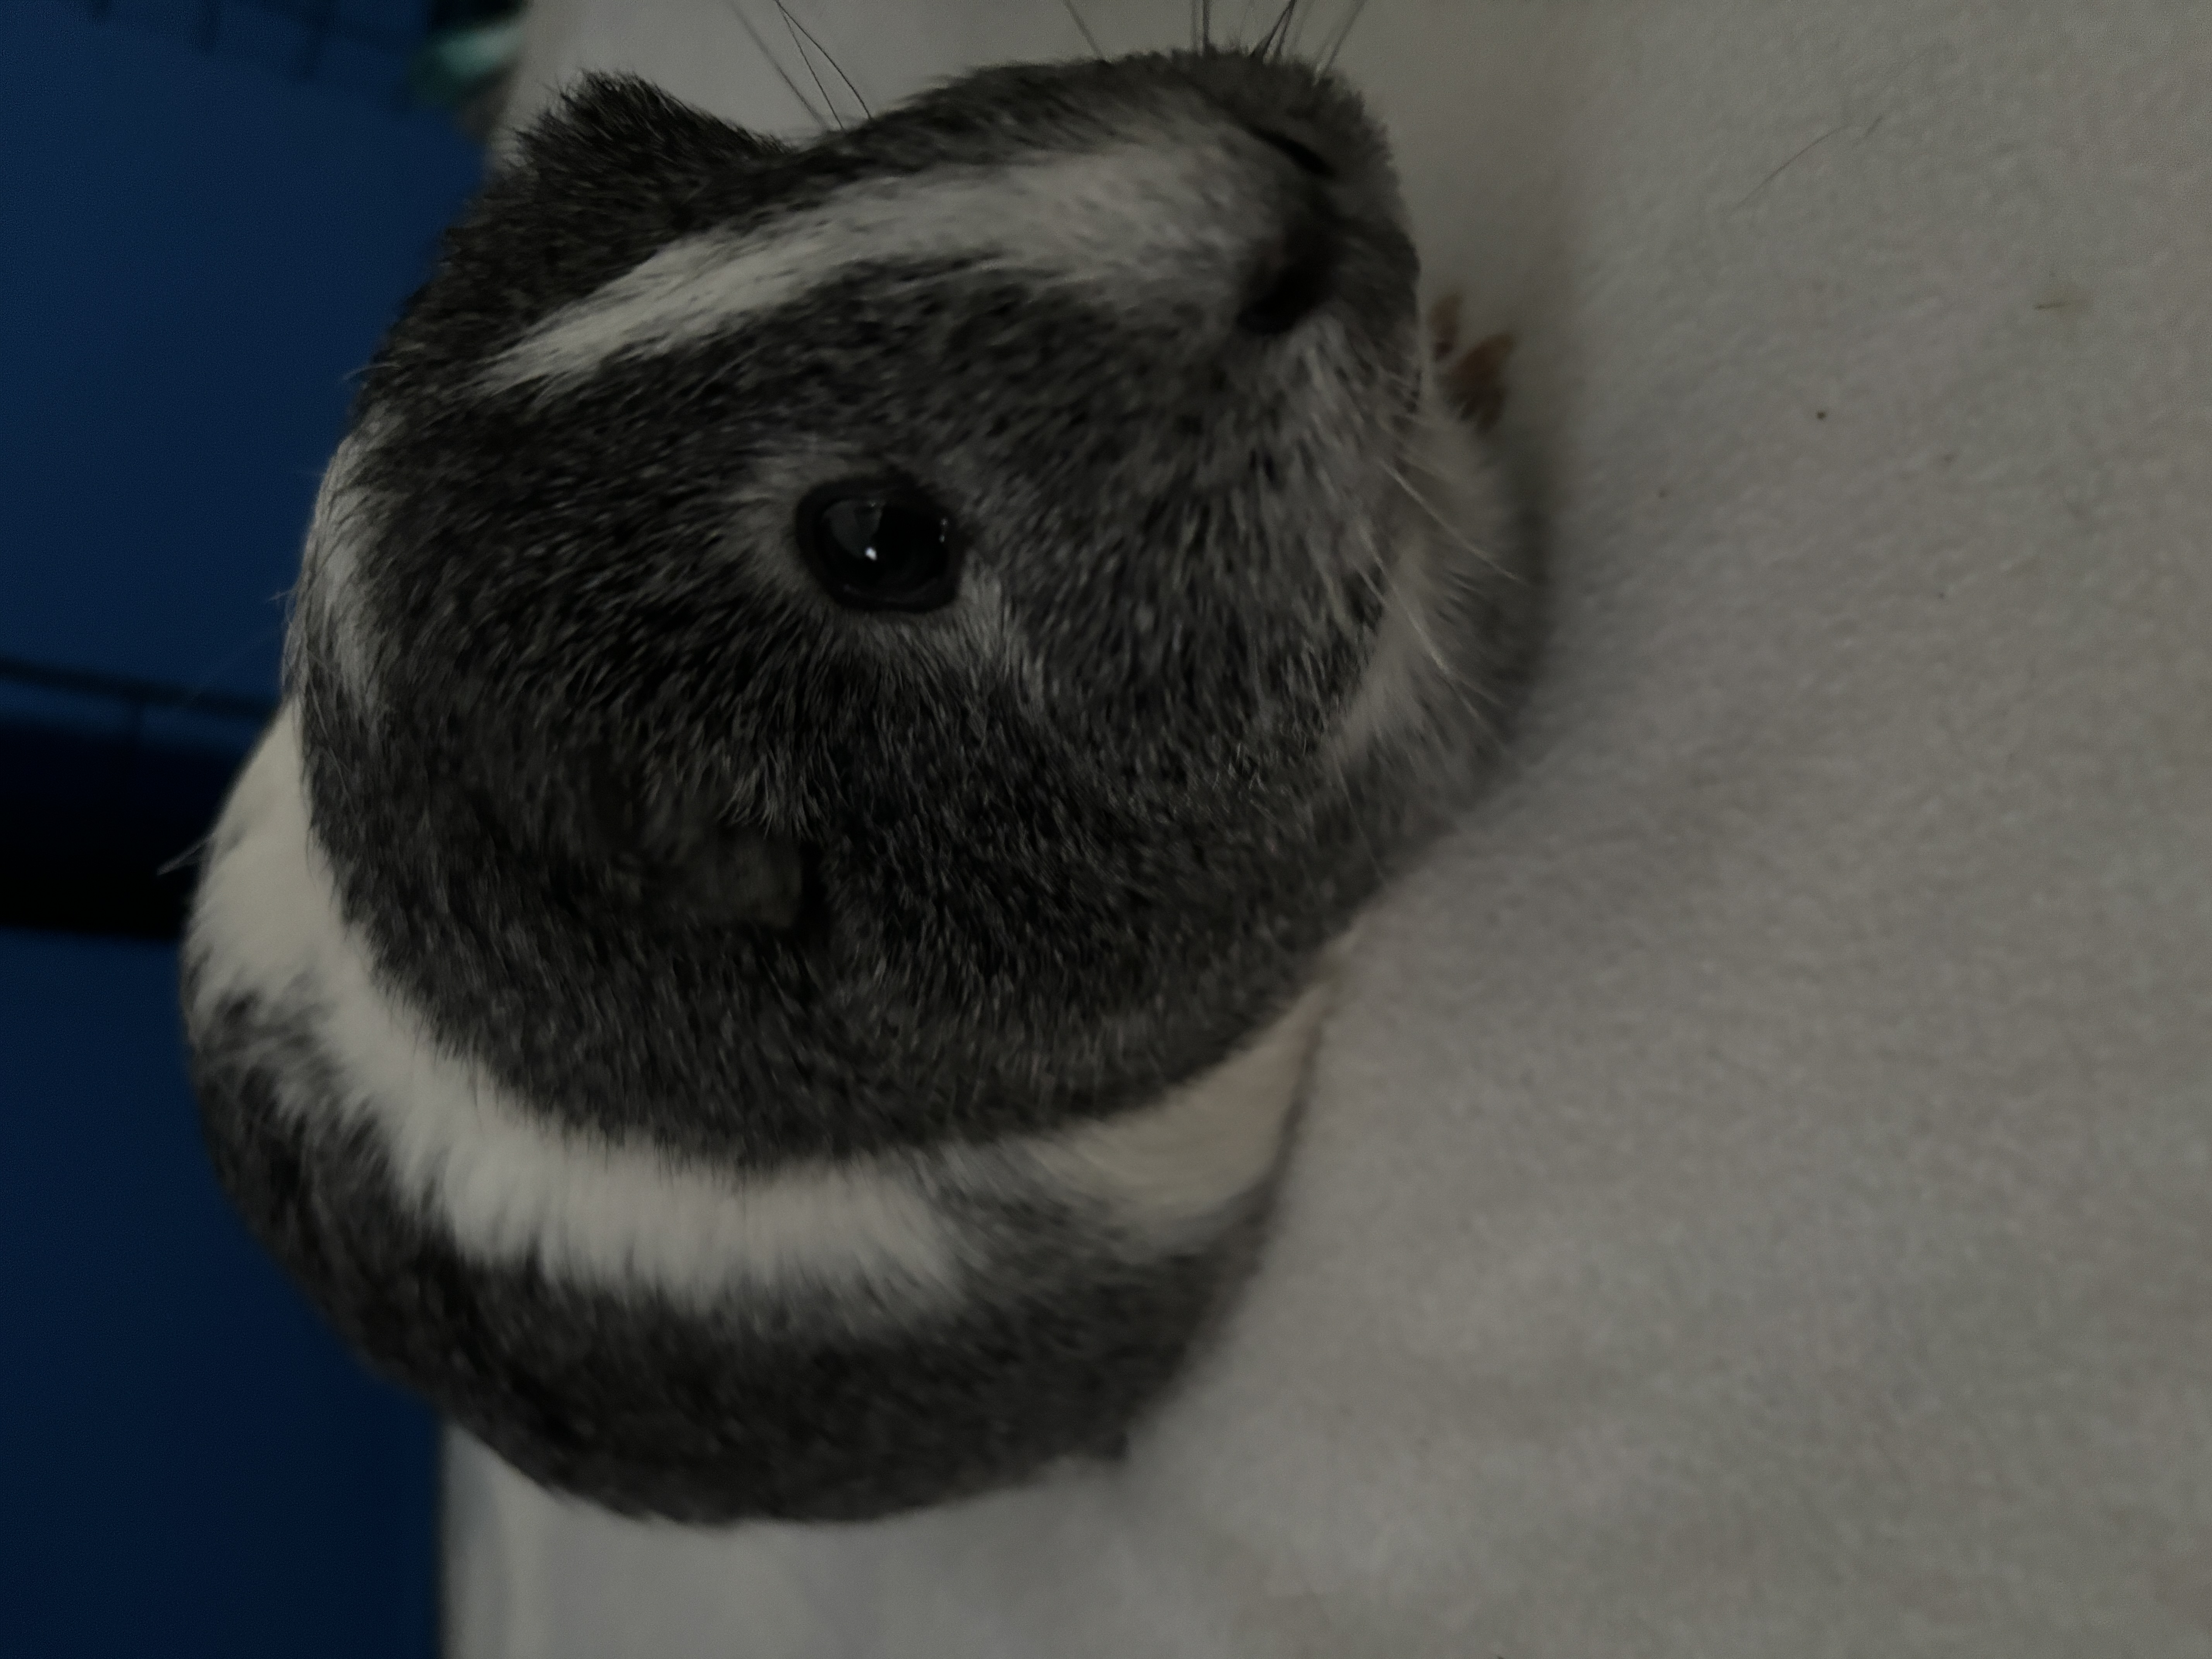

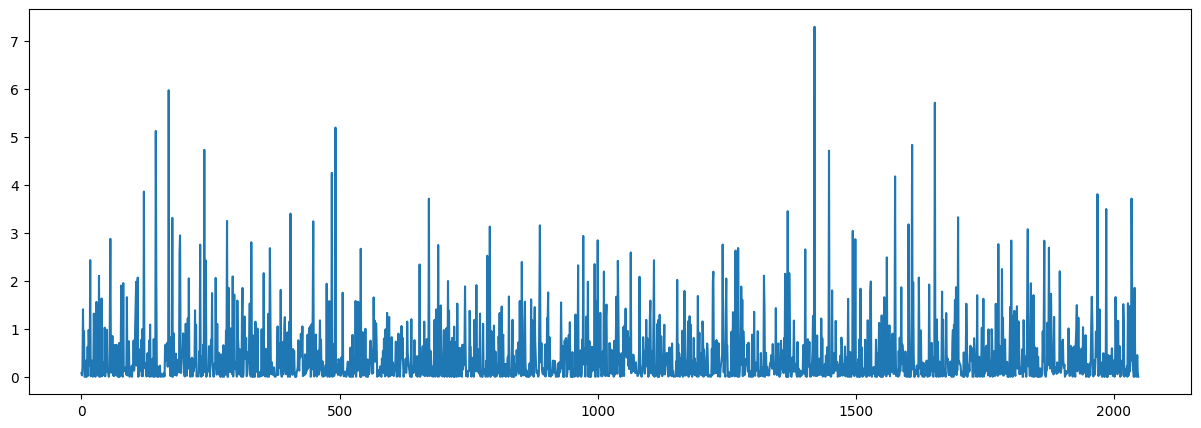

In [9]:
path = 'guinea_pigs/kiwi/IMG_6739.JPG'
img = image.load_img(path, target_size=model.input_shape[1:3])
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

feat = feat_extractor(x)


plt.figure(figsize=(15,5))
plt.plot(feat[0])

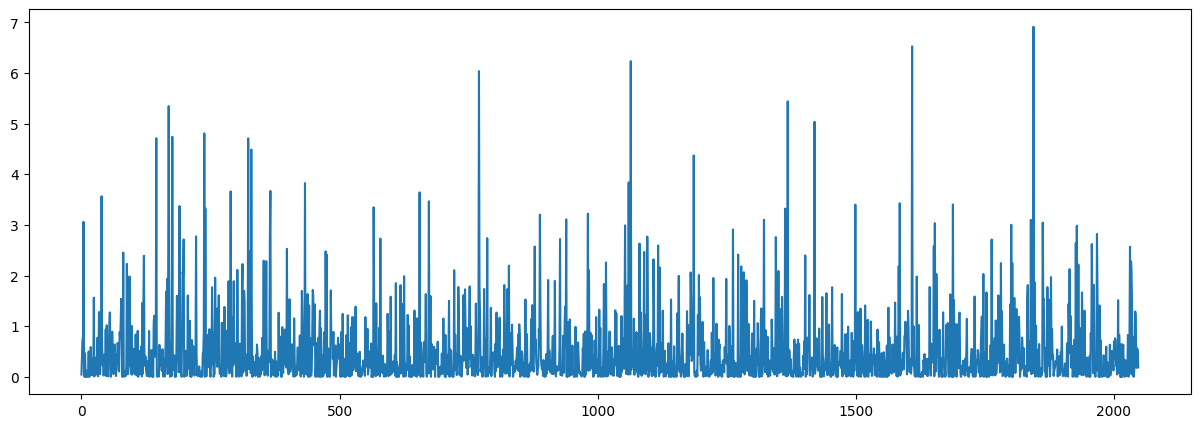

In [10]:
path2 = 'guinea_pigs/kinako/IMG_6834.JPG'
img = image.load_img(path2, target_size=model.input_shape[1:3])
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

feat2 = feat_extractor(x)


plt.figure(figsize=(15,5))
plt.plot(feat2[0])

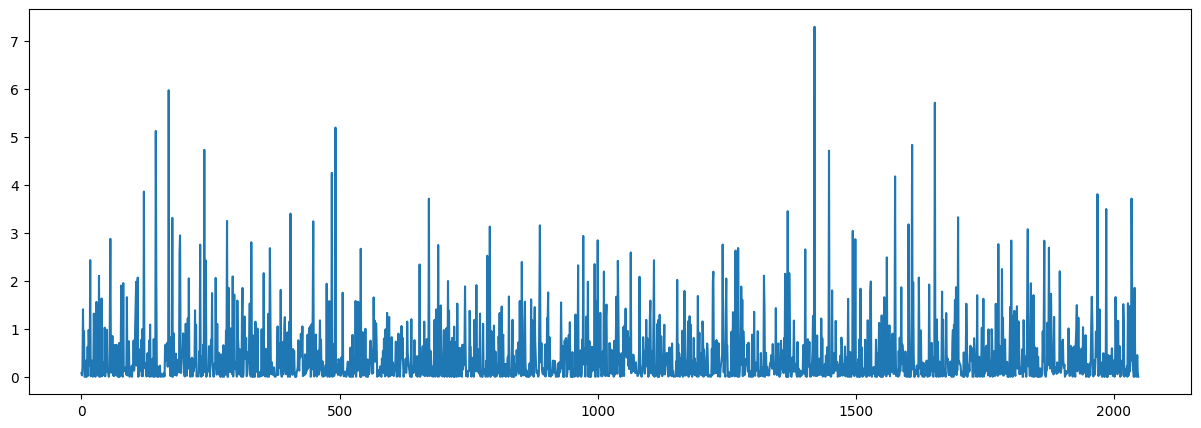

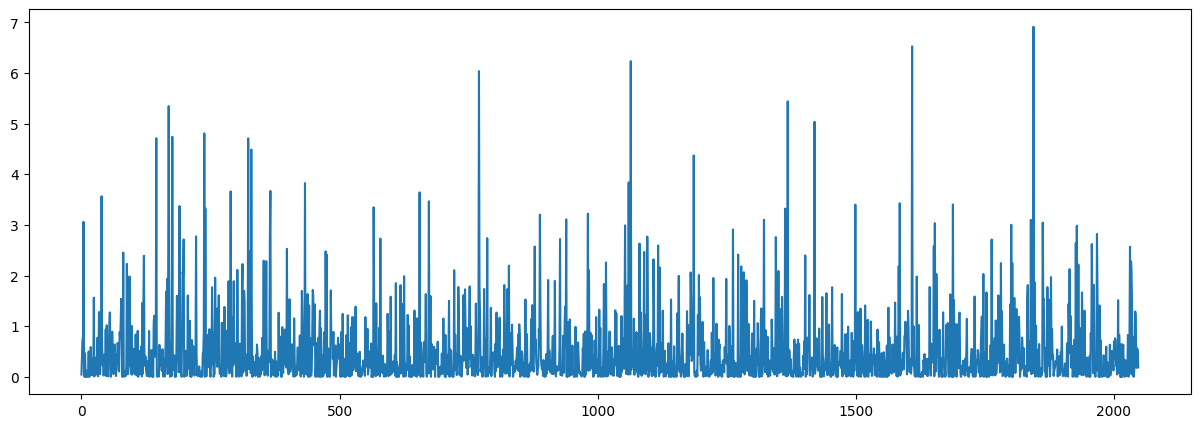

In [11]:
plt.figure(figsize=(15,5))
plt.plot(feat[0])

plt.figure(figsize=(15,5))
plt.plot(feat2[0])

In [15]:
# input: path to directory full of images
# output: list of image paths from directory
def get_image_paths(image_path):
    extensions = ['.jpg', '.png', '.jpeg']
    # get list of image paths
    images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(image_path) for f in filenames if os.path.splitext(f)[1].lower() in extensions]
    return images

# input: list of image paths, extracted feature array
# output appended extracted feature array
# opens each image, extracts the feature vector using ResNet50, and appends it to the feature array
def extract_features(images, features):
    for image_path in images:
        ext_feat = get_extracted_features(image_path)
        features.append(ext_feat)
    return features

def get_extracted_features(image_path):
    img, x = preprocess_image(image_path, model)
    ext_feat = feat_extractor.predict(x)[0]
    return ext_feat

In [16]:
# get image paths
image_path = './animals/animals/'
images = get_image_paths(image_path)

# list of extracted features
features = []

# get extracted features 
features = extract_features(images, features)

# notice when completed
print('finished extracting features for %d images' % len(images))

1/1 [==============================] - 0s 117ms/step
finished extracting features for 5400 images


PCA!

In [17]:
features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

In [ ]:
# pickle file 
pickle.dump([images, pca_features, pca], open('feature_extractor.p', 'wb'))

## Importing new images

In [18]:
# identify new image path
new_image_path = './guinea_pigs/'

# load data from pickle file
with open('./feature_extractor.p', 'rb') as file:
    images, pca_features, pca = pickle.load(file)
    
# get new image paths
new_images = get_image_paths(new_image_path)

In [19]:
# use same feature extractor
new_features = []
new_features = extract_features(new_images, new_features)

# project into extracted images into pca space
new_pca_features = pca.transform(new_features)

# add to pickle file
images += new_images
pca_features = np.vstack([pca_features, new_pca_features])
features = np.vstack([features, new_features])

    
# Save the updated data to the pickle file
with open('./feature_extractor_v2.p', 'wb') as file:
    pickle.dump([images, pca_features, pca], file)

1/1 [==============================] - 0s 133ms/step


## Searching phase 

### Feature vector extraction

In [20]:
# path to query image
query_image = '.\guinea_pigs\kiwi\IMG_6739.JPG'

# extract features
query_features = []
query_features.append(get_extracted_features(query_image))

# project into pca state
query_pca_features = pca.transform(query_features)[0]

1/1 [==============================] - 0s 118ms/step


### Similarity Score

In [21]:

def get_top_five_images(query_image, pca_features):
    num_of_results = 5
    
    #get cosine distance btw the query and the other pca features
    distances = [distance.cosine(query_image, feat) for feat in pca_features]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_of_results+1]

    return idx_closest

def get_concatenated_images(indexes, thumb_height, images):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Text(0.5, 1.0, 'RESULTS PCA')

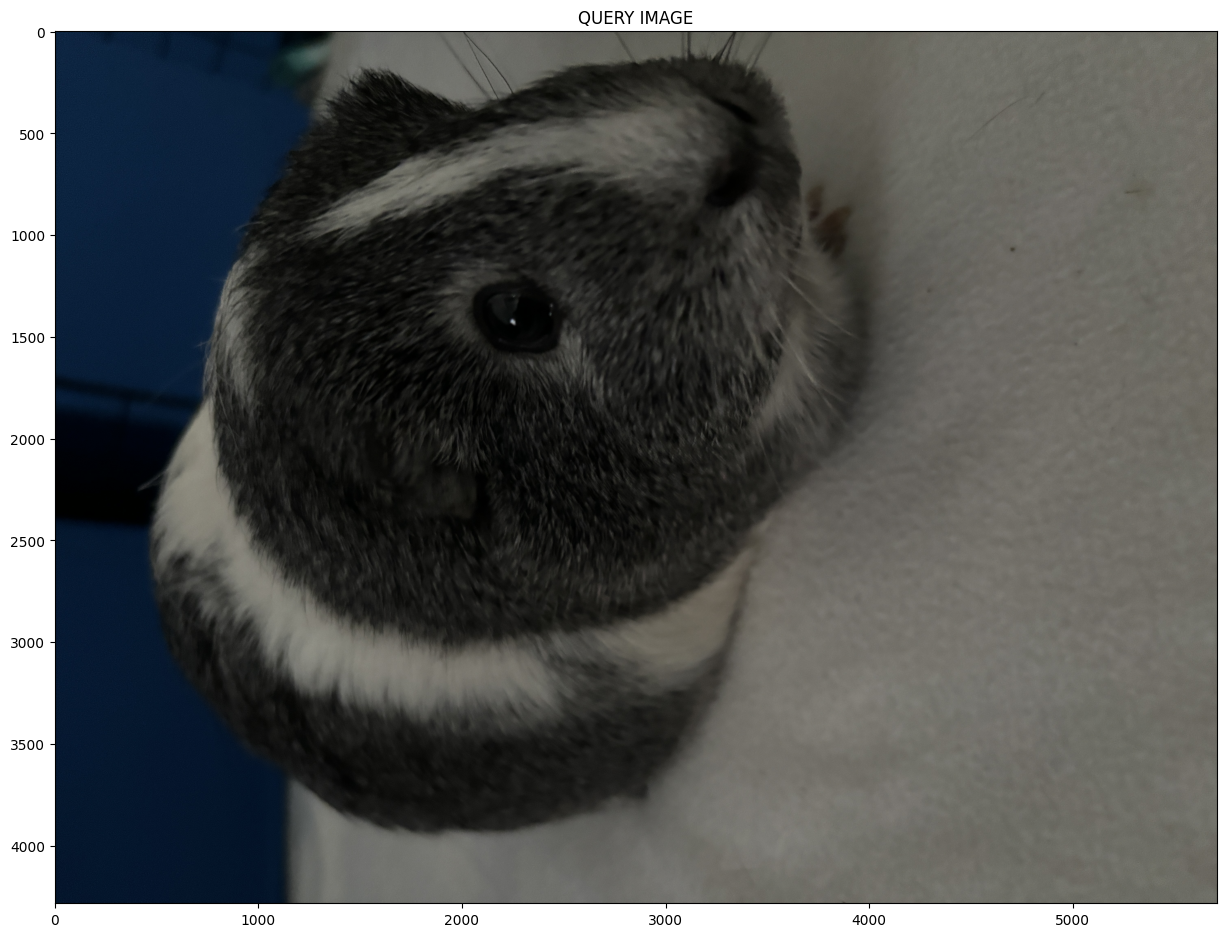

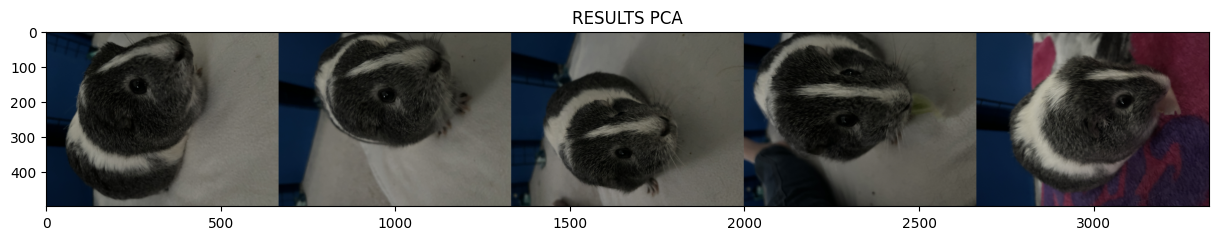

In [22]:
# load data from pickle file
with open('./feature_extractor_v2.p', 'rb') as file:
    images, pca_features, pca = pickle.load(file)

# load query image
img = image.load_img(query_image)

# display the query image
plt.figure(figsize = (15,12))
plt.imshow(img)
plt.title('QUERY IMAGE')

top_five = get_top_five_images(query_pca_features, pca_features)
image_results = get_concatenated_images(top_five, 500, images)

# display the resulting images
plt.figure(figsize = (15,12))
plt.imshow(image_results)
plt.title("RESULTS PCA")